#CALICO

# **Trabajo Práctico 1 - Parte 1 - Juego: Calico**
---
## ***Procesamiento del Lenguaje Natural - TUIA***

Autores:
* de Brito, Nicolas
* Giacone, Agustin
* Ippolito, Marco
* Rizzotto, Camila

##FORO

####Librerias

In [ ]:
# Instalar dependencias
!pip install selenium webdriver-manager > /dev/null

# Importar librerías
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time
import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

from google.colab import auth
auth.authenticate_user()

# Configurar Chrome en modo headless para Colab
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")



####Extraccion

In [ ]:
# Variable para acumular todo el contenido
contenido_total = ""

#Paginas que vamos a recorrer
paginas = range(1,7)

for nro_pagina in paginas:
  # Crear el driver con WebDriver Manager
  driver = webdriver.Chrome(options=chrome_options)

  driver.get("https://boardgamegeek.com/boardgame/283155/calico/forums/0?pageid="+str(nro_pagina)) #https://boardgamegeek.com/boardgame/283155/calico/forums/0
  time.sleep(2)
  # Capturar los links de los hilos
  hilos = driver.find_elements(By.CSS_SELECTOR, "li.summary-item h3 a")

  print(f"Buscamos dentro de la pagina {str(nro_pagina)}")

  urls = []
  for hilo in hilos:
      href = hilo.get_attribute("href")
      if href.startswith("/"):
          href = "https://boardgamegeek.com" + href
      urls.append(href)

  print(f"Encontramos {len(urls)} hilos!")

  # Definimos cuántos hilos queremos procesar para la prueba
  limite_hilos = 3

  # Recorremos solo los primeros 3 hilos
  #for idx, url in enumerate(urls[:limite_hilos], start=1):
  for idx, url in enumerate(urls, start=1):
      print(f"Entrando al hilo {idx}: {url}...")
      driver.get(url)
      time.sleep(2)

      try:
          # Título del tópico dentro del primer post
          titulo = driver.find_element(By.CSS_SELECTOR, "h1.forum-header__title span[itemprop='headline']").text
          print(f"📌 Título del tópico: {titulo}")
      except Exception as e:
          print(f"No se encontró título del tópico: {e}")
          titulo = "sin_titulo"

      # Capturar comentarios
      comentarios = []
      try:
          comentarios_html = driver.find_elements(By.CSS_SELECTOR, ".post-body")
          for comentario in comentarios_html:
              texto = comentario.text.strip()
              if texto:
                  comentarios.append(texto)
          print(f"🗨️  Encontrados {len(comentarios)} comentarios")
      except Exception as e:
          print(f"Error capturando comentarios: {e}")

      # Agregar al contenido total
      contenido_total += f"\n\n-\n"
      contenido_total += f"Título: {titulo}\n"
      contenido_total += f"-\n"

      for jdx, texto in enumerate(comentarios, start=1):
          contenido_total += f"\nComentario {jdx}:\n{texto}\n"

nombre_archivo = "foro-calico.txt"

with open(nombre_archivo, "a", encoding="utf-8") as f:
    f.write(contenido_total)

drive_service = build('drive', 'v3')
folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'
file_metadata = {"name": nombre_archivo, "parents": [folder_id]}
media = MediaFileUpload(nombre_archivo, mimetype="text/plain")
uploaded = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
#os.remove(nombre_archivo)


##PDFs

###Librerias

In [ ]:
!apt-get update
!pip install pdf2image
!apt-get install -y poppler-utils
!apt-get install -y tesseract-ocr tesseract-ocr-spa tesseract-ocr-ita tesseract-ocr-fra tesseract-ocr-deu poppler-utils
!pip install pytesseract

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

from pdf2image import convert_from_path
import pytesseract

auth.authenticate_user()
from oauth2client.client import GoogleCredentials

import os

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

###Extraccion

In [ ]:
#Descarga archivos localmente
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '1MzhfX2Yp_JgdCuc4c1-onn1tMl6rgm0g'

file_list = drive.ListFile({'q': f"'{folder_id}' in parents and mimeType='application/pdf' and trashed=false"}).GetList()
pdfs_local = []

for file in file_list:
    print(f"Descargando: {file['title']}")
    file_path = f"/content/{file['title']}"
    file.GetContentFile(file_path)
    pdfs_local.append(file_path)

In [ ]:
# Filtramos los archivos PDF
archivos_pdf = [f for f in os.listdir("/content") if f.endswith(".pdf")]

for pdf in archivos_pdf:
  #Convierto PDF a Imagenes
  imagenes = convert_from_path(pdf, dpi=300)

  #El idioma esta en la primera parte del nombre
  lang_pdf = pdf.split("_")[0]

  # Extraer texto con OCR
  texto_ocr = [pytesseract.image_to_string(img, lang=lang_pdf) for img in imagenes]
  texto_final = "\n".join(texto_ocr)

  #Guarda TXT
  nombre_archivo = "pdf-"+pdf.split(".")[0]+".txt"

  with open(nombre_archivo, "a", encoding="utf-8") as f:
      f.write(texto_final)

  drive_service = build('drive', 'v3')
  folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'
  file_metadata = {"name": nombre_archivo, "parents": [folder_id]}
  media = MediaFileUpload(nombre_archivo, mimetype="text/plain")
  uploaded = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()

##VIDEOS

###Librerias

In [ ]:
!pip install --upgrade youtube-transcript-api google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from youtube_transcript_api import YouTubeTranscriptApi
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.9 MB/s eta 0:00:00


###Extraccion

In [ ]:
drive_service = build('drive', 'v3')
folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'

videos = [
    ('BH8iB8Rk5G0', "Video-Instrucciones_Español"),
    ('1lr9ShE3zSw', "Video-Reseña_Español"),
    ('JEIsKOV6Hmc', "Video-Partida_Rápida"),
    ('NmnMKkT3tBI', "Video-Instrucciones_Inglés"),
    ('6KaefnrYZ-w', "Video-Review_Ingles"),
    ('qUr777lcCAQ', "Video-Instrucciones_Francés"),
    ('_NxrDnlA7OM', "Video-Instrucciones_Alemán"),
    ('azU-1mQWzqo', "Video-Review_Alemán"),
    ('liTc23qpJnQ', "Video-Instrucciones_Portugués"),
    ('ToJkaOlusTs', "Video-Review_Portugués"),
    ('WlYk6guaMEg', "Video-Instrucciones_Italiano"),
    ('J-VjECYDKk0', "Video-Review_Italiano"),
]

for video_id, titulo_manual in videos:
        transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['es', 'en', 'fr', 'pt', 'it', 'de'])
        texto = ' '.join([x['text'] for x in transcript])
        nombre_archivo = titulo_manual.replace(" ", "_").replace(":", "").lower() + ".txt"
        with open(nombre_archivo, "w", encoding="utf-8") as f:
            f.write(f"{titulo_manual}\n")
            f.write(texto)
        file_metadata = {"name": nombre_archivo, "parents": [folder_id]}
        media = MediaFileUpload(nombre_archivo, mimetype="text/plain")
        uploaded = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
        print(f"Subido: {nombre_archivo} (ID: {uploaded['id']})")
        os.remove(nombre_archivo)

print("Finalizado.")

##WIKIPEDIA

###Librerias


In [ ]:
import wikipediaapi
from google.colab import drive
import os

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google.colab import auth
auth.authenticate_user()

###Extraccion

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Configurar Wikipedia API
wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='Mozilla/5.0 (X11; Linux x86_64)'
)

page = wiki.page("Calico_(board_game)")

# Extraer secciones
intro = page.summary
gameplay = page.section_by_title("Gameplay").text
contenido = f"INTRODUCCIÓN:\n\n{intro}\n\nGAMEPLAY:\n\n{gameplay}"


nombre_archivo = "wikipedia-calico.txt"
with open(nombre_archivo, 'w', encoding='utf-8') as f:
    f.write(contenido)

# Subir archivo a carpeta de Drive específica
folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'
drive_service = build('drive', 'v3')
file_metadata = {"name": nombre_archivo, "parents": [folder_id]}
media = MediaFileUpload(nombre_archivo, mimetype="text/plain")
uploaded = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()

print(f"Archivo subido a Drive con ID: {uploaded.get('id')}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo subido a Drive con ID: 1UlXeA8L6EFlr_Tbib7t7Litff2y_3m__


##ARTICULOS

####Librerías

In [ ]:
%%capture
!pip install beautifulsoup4 requests
import requests
from bs4 import BeautifulSoup

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

from google.colab import auth
auth.authenticate_user()

####Extracción

In [ ]:
url = 'https://misutmeeple.com/2021/02/resena-calico/'

# Enviar una solicitud GET
response = requests.get(url)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    html_content = response.text
    print("Página obtenida con éxito")
else:
    print(f"Error {response.status_code}")

Página obtenida con éxito


In [ ]:
soup = BeautifulSoup(html_content, "html.parser")

titulo = soup.find("title").text

parrafos = soup.find_all("p")
# for i, parrafo in enumerate(parrafos[:5], 1):
#     print(f"{i}. {parrafo.text}")

preparacion_partida = soup.find("ol")
# items = preparacion_partida.find_all("li")
# for i, item in enumerate(items, 1):
#     print(f"{i}. {item.text.strip()}")

comentarios = soup.select(".comment-body")
# for i, comentario in enumerate(comentarios[:6], 1):
#     print(f"{i} {comentario.find(class_='comment-content').text}")

In [ ]:
listas = soup.find_all("ul")
#for i, lista in enumerate(listas, 1):
#    print(f"{i}. {lista.text}")
contenido_caja_juego = listas[1]
proceder_en_turnos = listas[2]
recuento_final_puntos = listas[3]
criterios_empate = listas[4]
variantes = listas[5]

In [ ]:
nombre_archivo = 'articulo-misutmeeple_calico.txt'
with open(nombre_archivo, "w", encoding="utf-8") as f:
    f.write(f"Título: {titulo}\n\n")

    f.write("Párrafos:\n")
    for p in parrafos:
        texto = p.text.strip()
        if texto:
            f.write(f"- {texto}\n")
    f.write("\n")

    f.write("Preparación de la partida:\n")
    for i, item in enumerate(preparacion_partida.find_all("li"), 1):
        f.write(f"{i}. {item.text.strip()}\n")
    f.write("\n")

    def escribir_lista(nombre_seccion, lista_ul):
        f.write(f"{nombre_seccion}:\n")
        for i, item in enumerate(lista_ul.find_all("li"), 1):
            f.write(f"{i}. {item.text.strip()}\n")
        f.write("\n")

    escribir_lista("Contenido de la caja del juego", contenido_caja_juego)
    escribir_lista("Proceder en los turnos", proceder_en_turnos)
    escribir_lista("Recuento final de puntos", recuento_final_puntos)
    escribir_lista("Criterios de desempate", criterios_empate)
    escribir_lista("Variantes", variantes)

    f.write("Comentarios:\n")
    for i, comentario in enumerate(comentarios, 1):
        texto = comentario.text.strip()
        if texto:
            f.write(f"{i}. {texto}\n")

drive_service = build('drive', 'v3')
folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'
file_metadata = {"name": nombre_archivo, "parents": [folder_id]}
media = MediaFileUpload(nombre_archivo, mimetype="text/plain")
uploaded = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()

##ESTADISTICAS

###Librerias

In [ ]:
# Instalar dependencias
!pip install selenium webdriver-manager > /dev/null

# Importar librerías
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time

# Configurar Chrome en modo headless para Colab
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")


import os
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import csv
from google.colab import auth
auth.authenticate_user()

###Extraccion

In [ ]:
driver = webdriver.Chrome(options=chrome_options)

driver.get("https://boardgamegeek.com/boardgame/283155/calico/stats")
time.sleep(2)

items = driver.find_elements(By.CLASS_NAME, "outline-item")

datos = {}

for item in items:
    try:
        titulo = item.find_element(By.CLASS_NAME, "outline-item-title").text.strip()
        descripcion = item.find_element(By.CLASS_NAME, "outline-item-description").text.strip()
        descripcion = descripcion.split("\n")[0].strip('"')
        datos[titulo] = descripcion
    except:
        continue


nombre_archivo = 'estadisticas-calico.csv'

with open(nombre_archivo, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile,delimiter=';')
    writer.writerow(['estadistica', 'valor'])  # encabezado
    for key, value in datos.items():
        writer.writerow([key, value])


drive_service = build('drive', 'v3')
folder_id = '1qVCY84V43x97OZTA1xYVz6JoJypFdACy'
file_metadata = {"name": nombre_archivo, "parents": [folder_id]}
media = MediaFileUpload(nombre_archivo, mimetype="text/plain")
uploaded = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()


##RELACIONES

###Librerías

In [ ]:
!apt-get update
!pip install easyocr > /dev/null
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

import easyocr
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import defaultdict

import os

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,665 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 1,923 kB in 1s (1,436 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat

###Extracción

In [ ]:
#Descarga archivos localmente
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

folder_id = '12D2Iz4tydI_rYZwnv9tJttLvumERIx69'

file_list = drive.ListFile({'q': f"'{folder_id}' in parents and mimeType='image/png' and trashed=false"}).GetList()
creditos_local = []

for file in file_list:
    print(f"Descargando: {file['title']}")
    file_path = f"/content/{file['title']}"
    file.GetContentFile(file_path)
    creditos_local.append(file_path)

Descargando: creditos-calico.png


In [ ]:
# Cargar la imagen
img_path = "/content/creditos-calico.png"

# Crea un lector OCR en inglés y español
reader = easyocr.Reader(['en','es'])

# Leer texto con coordenadas
results = reader.readtext(img_path)

# Agrupar por eje vertical (líneas)
lineas = defaultdict(list)
tolerance = 15  # margen de alineación vertical

for bbox, text, prob in results:
    top = int(bbox[0][1])
    linea_clave = top // tolerance
    lineas[linea_clave].append((bbox[0][0], text))  # agrupamos por eje x también

# Ordenar líneas y convertirlas a listas de celdas
tabla = []
for clave in sorted(lineas):
    fila = sorted(lineas[clave], key=lambda x: x[0])  # ordenar horizontalmente
    textos = [texto for _, texto in fila]
    tabla.append(textos)

# Crear DataFrame
relaciones_calico = pd.DataFrame(tabla)

# Mostrar valores
relaciones_calico

0                    1             2
0                          Full Credits                 None          None
1                          Primary Name               Calico          None
2                       Alternate Names  Calico 0 Znlróyaroç          None
3        Calico: Foltok; cicák, takarók                 None          None
4                               Pellsek                 None          None
..                                  ...                  ...           ...
57       Digital Implementations: Steam                 None          None
58  Digital Implementations: Tabletopia                 None          None
59  Players: Games with Solitaire Rules                 None          None
60                       Series: Calico                 None          None
61                        Theme: Sewing             Knitting  Cloth-Making

[62 rows x 3 columns]

In [ ]:
#Realizamos uno nuevo, limpio, con formato requerido por la cátedra
relaciones = ['Year Released', 'Designer', 'Solo Designer', 'Artist'] + ['Publisher'] * 17 + ['Developer'] * 5 + ['Graphic Designer'] * 3 + ['Categorie'] * 2 + ['Mechanism'] * 9 + ['Family'] * 8
sujeto_2 = [relaciones_calico[1][10], relaciones_calico[1][11], relaciones_calico[1][12], relaciones_calico[1][13], relaciones_calico[1][14]] + list(relaciones_calico[0][15:31]) + [relaciones_calico[1][31]] + list(relaciones_calico[0][32:36]) + [relaciones_calico[1][36]] + list(relaciones_calico[0][37:39]) + [relaciones_calico[1][43]] + [relaciones_calico[0][44]] + [relaciones_calico[1][45]] + list(relaciones_calico[0][46:50]) + ['Pattern Building', 'Set Collection' , 'Solo / Solitaire Game', 'Tile Placement'] + [relaciones_calico[1][54]] + list(relaciones_calico[0][55:61]) + ['Theme: Sewing / Knitting / Cloth-Making']
sujeto_1 = ['Calico'] * len(sujeto_2)

creditos_calico = pd.DataFrame()
creditos_calico['SUJETO 1'] = sujeto_1
creditos_calico['RELACION'] = relaciones
creditos_calico['SUJETO 2'] = sujeto_2

creditos_calico

SUJETO 1          RELACION                                  SUJETO 2
0    Calico     Year Released                                      2020
1    Calico          Designer                                Kevin Russ
2    Calico     Solo Designer                          Shawn Stankewich
3    Calico            Artist                                Beth Sobel
4    Calico         Publisher                             Flatout Games
5    Calico         Publisher               Alderac Entertainment Group
6    Calico         Publisher                            Arclight Games
7    Calico         Publisher                               CrowD Games
8    Calico         Publisher                         Cryptic Cardboard
9    Calico         Publisher                              Gém Klub Kft
10   Calico         Publisher                                Grok Games
11   Calico         Publisher                     Hid Konem (Xip KoheM)
12   Calico         Publisher                      Kaissa Chess & Games
13   Calico         Publisher                       Little Rocket Games
14   Calico         Publisher                            Lord of Boards
15   Calico         Publisher                          Lucky Duck Games
16   Calico         Publisher                             Maldito Games
17   Calico         Publisher                                    MINDOK
18   Calico         Publisher                             Popcorn Games
19   Calico         Publisher                              Ravensburger
20   Calico         Publisher                        White Goblin Games
21   Calico         Developer                               David lezzi
22   Calico         Developer                             Molly Johnson
23   Calico         Developer                             Robert Melvin
24   Calico         Developer                                Kevin Russ
25   Calico         Developer                          Shawn Stankewich
26   Calico  Graphic Designer                             Dylan Mangini
27   Calico  Graphic Designer                                Kevin Russ
28   Calico  Graphic Designer                          Shawn Stankewich
29   Calico         Categorie                                   Animals
30   Calico         Categorie                                    Puzzle
31   Calico         Mechanism                                 Enclosure
32   Calico         Mechanism                          End Game Bonuses
33   Calico         Mechanism                             Grid Coverage
34   Calico         Mechanism                              Hexagon Grid
35   Calico         Mechanism                             Open Drafting
36   Calico         Mechanism                          Pattern Building
37   Calico         Mechanism                            Set Collection
38   Calico         Mechanism                     Solo / Solitaire Game
39   Calico         Mechanism                            Tile Placement
40   Calico            Family                             Animals: Cats
41   Calico            Family                 Crowdfunding: Kickstarter
42   Calico            Family  Digital Implementations: Apple App Store
43   Calico            Family            Digital Implementations: Steam
44   Calico            Family       Digital Implementations: Tabletopia
45   Calico            Family       Players: Games with Solitaire Rules
46   Calico            Family                            Series: Calico
47   Calico            Family   Theme: Sewing / Knitting / Cloth-Making

In [ ]:
# Construir servicio Drive
drive_service = build('drive', 'v3')

folder_id = '1TXIFUXl7RVLgjLxmuNM7g5jzftzUxeGU'  # carpeta destino -> relaciones

# Guardar CSV
csv_filename = "relaciones-calico.csv"
creditos_calico.to_csv(csv_filename, index=False)

# Subir CSV a Google Drive
csv_metadata = {"name": csv_filename, "parents": [folder_id]}
csv_media = MediaFileUpload(csv_filename, mimetype="text/csv")
uploaded_csv = drive_service.files().create(body=csv_metadata, media_body=csv_media, fields="id").execute()

print(f"CSV subido: https://drive.google.com/file/d/{uploaded_csv['id']}")

✅ CSV subido: https://drive.google.com/file/d/1YN1RLR1_hNnFGJddeGuf6Max0s8yjF-o


##ANALISIS POST EXTRACCION

###Librerias

In [ ]:
!pip install wordcloud

!pip install tabulate
from tabulate import tabulate

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticación
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd

# Instalar la librería wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

###Extraccion

####Resumen de archivos, palabras y caracteres

In [ ]:
# ID de la carpeta que contiene los archivos de texto
folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'

# Buscar archivos en la carpeta
file_list = drive.ListFile({
    'q': f"'{folder_id}' in parents and trashed=false"
}).GetList()

data = []

for file in file_list:
    if file['title'].endswith('.txt'): #solo los .txt
        #print(f"Descargando {file['title']}...")
        file.GetContentFile(file['title'])  # descarga localmente

        with open(file['title'], 'r', encoding='utf-8') as f:
            content = f.read()
            num_chars = len(content)
            num_words = len(content.split())

            data.append({
                'nombre_archivo': file['title'],
                'palabras': num_words,
                'caracteres': num_chars
            })

df = pd.DataFrame(data)
df['origen'] = df['nombre_archivo'].str.split('-').str[0]

In [ ]:
df_totales = df.groupby('origen').agg(
    total_palabras=('palabras', 'sum'),
    total_caracteres=('caracteres', 'sum'),
    cantidad_archivos=('origen', 'count')
).reset_index()

print('\n')
print('ANALISIS DE LA INFORMACION EXTRAIDA\n')
print(tabulate(df.values, headers=df.columns, tablefmt='psql'))
print(tabulate(df_totales.values, headers = df_totales.columns, tablefmt='psql'))
print("Total de archivos: " + str(df_totales['cantidad_archivos'].sum()))
print("Total de palabras: " + str(df_totales['total_palabras'].sum()))
print("Total de caracteres: " + str(df_totales['total_caracteres'].sum()))



ANALISIS DE LA INFORMACION EXTRAIDA

+-----------------------------------------------+------------+--------------+-----------+
| nombre_archivo                                |   palabras |   caracteres | origen    |
|-----------------------------------------------+------------+--------------+-----------|
| articulo-misutmeeple_calico.txt               |       3428 |        19814 | articulo  |
| wikipedia-calico.txt                          |        180 |         1038 | wikipedia |
| pdf-fra_Calico_Rules_First_Edition_French.txt |       6149 |        35473 | pdf       |
| pdf-ita_Calico_Regolamento.txt                |       5060 |        31060 | pdf       |
| pdf-spa_calico.txt                            |       5755 |        31385 | pdf       |
| pdf-spa_Calico_Reglas_a_la_JcK.txt            |        934 |         5284 | pdf       |
| pdf-eng_Calico_Condensed_Rules.txt            |        422 |         2263 | pdf       |
| pdf-eng_Calico_Rules_First_Edition.txt        |       5266 

####Nube de palabras del foro

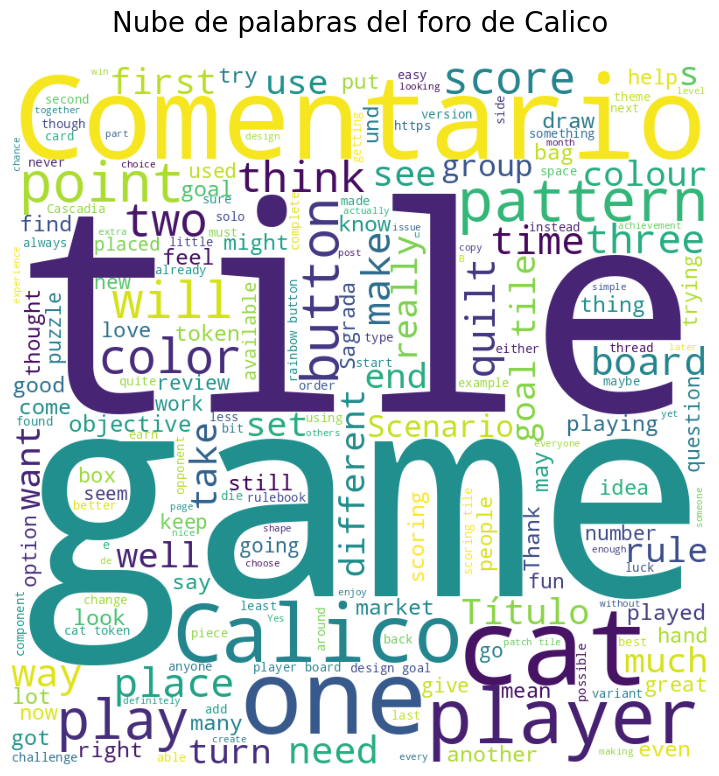

In [ ]:
folder_id = '1ah7EuP7ySft_QFSMH8Qt67k_NLi9EtIA'

# Buscar archivos en la carpeta
file_list = drive.ListFile({
    'q': f"'{folder_id}' in parents and trashed=false"
}).GetList()

data = []
for file in file_list:
    if (file['title'].endswith('.txt')) and (file['title'].split("-")[0] == "foro"): #me quedo solo con el txt del foro
        file.GetContentFile(file['title'])  # descarga localmente

        with open(file['title'], 'r', encoding='utf-8') as f:
            content = f.read()
            num_chars = len(content)
            num_words = len(content.split())

            data.append({
                'nombre_archivo': file['title'],
                'palabras': num_words,
                'caracteres': num_chars
            })

text = content

# Crear la nube de palabras
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Generamos grafico
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Nube de palabras del foro de Calico", fontsize=20,pad=25)

plt.show()